Name: Namrata Bhorade

Class: BE COMPS

Batch: A

UID: 2018130004

Roll No.: 03

# CEEL 82B, Data Science, 2022
# Lab 7: Text Analysis


**Objective**: Separating Spam From Ham

This notebook elaborates the process of email classification using a text corpus dataset. It explains the steps for creating the corpus by performing cleaning, tokenization, stemming, etc. The document term matrix is then created from the corpus for classification. The classification is performed by using three models namely, Random Forest, Naive Bayes and CART and the performance is evaluated using various evaluation metrics.

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt
import plotly.express as px
import string 
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

from string import punctuation


from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import MultinomialNB

from sklearn.tree import DecisionTreeClassifier, export_graphviz

from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, auc, classification_report

import re

from pylab import rcParams

from prettytable import PrettyTable

import random

import os

from prettytable import PrettyTable

import warnings
warnings.filterwarnings("ignore")

In [ ]:
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Problem 1.1 – Loading the Dataset

In [ ]:
email_data = pd.read_csv('/content/drive/MyDrive/DS-Lab/Lab/Exp7/emails.csv')
email_data_original = pd.read_csv('/content/drive/MyDrive/DS-Lab/Lab/Exp7/emails.csv')

In [ ]:
email_data

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1
...,...,...
5723,Subject: re : research and development charges...,0
5724,"Subject: re : receipts from visit jim , than...",0
5725,Subject: re : enron case study update wow ! a...,0
5726,"Subject: re : interest david , please , call...",0


## How many emails are in the dataset?

In [ ]:
email_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5728 entries, 0 to 5727
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5728 non-null   object
 1   spam    5728 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 89.6+ KB


**Ans - 5728**

There are 5728 emails in the dataset

## How many of the emails are spam?

In [ ]:
email_data.spam.value_counts()

0    4360
1    1368
Name: spam, dtype: int64

**Ans - 1368**

There are 1368 spam emails and 4360 ham emails in the dataset.

## Which word appears at the beginning of every email in the dataset? Respond as a lower-case word with punctuation removed.

In [ ]:
flag = True

email_data['text'] = email_data['text'].str.lower()

email_data['text'] = email_data['text'].str.replace('[{}]'.format(string.punctuation), '')

first_word = email_data.loc[0, 'text'].split()[0]

next_word = ''

for i in email_data.index:
    next_word = email_data.loc[i, 'text'].split()[0]
    if next_word != first_word:
        flag = False
        break

if flag==True:
    print("First word that appears in every email - ",first_word)

First word that appears in every email -  subject


**Ans - subject**

The word 'subject' appears at the beginning of every email in the dataset.

## Could a spam classifier potentially benefit from including the frequency of the word that appears in every email?	

Yes. This is because - 
* Each email has the word “subject” appear at least once, but the frequency with which 
it appears can us differentiate spam from ham. 
* For example, a long email chain would have the word “subject” appear a number of times, and this higher frequency might be indicative of a ham message.

First we calculate the frequecy of the word 'subject' in each email

In [ ]:
frequency_count_df = pd.concat([pd.DataFrame(email_data.text.str.count('subject')), pd.DataFrame(email_data['spam'])], axis=1)
frequency_count_df

,text,spam
0,1,1
1,1,1
2,1,1
3,1,1
4,1,1
...,...,...
5723,3,0
5724,2,0
5725,2,0
5726,5,0


In [ ]:
frequency_count_df.describe()

,text,spam
count,5728.000000,5728.000000
mean,1.781075,0.238827
std,1.270164,0.426404
min,1.000000,0.000000
25%,1.000000,0.000000
50%,1.000000,0.000000
75%,2.000000,0.000000
max,15.000000,1.000000


We can see that the word subject appears in emails for minimum 1 time and maximum of 15 times with mean frequency being 1.78

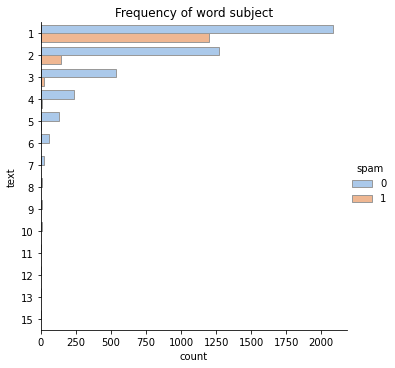

In [ ]:
sns.catplot(y="text", hue="spam", kind="count",palette="pastel", edgecolor=".6",data=frequency_count_df)
plt.title('Frequency of word subject')
plt.show()

The above plot shows the frequency of word subject along with the class distribution. We can see that the count is higher for class 0 i.e. ham for lower frequency and at higher frequency only ham class is present.

Hence, a spam classifier can potentially benefit from including the frequency of the word that appears in every email

## How many characters are in the longest email in the dataset (where longest is measured in terms of the maximum number of characters)?

In [ ]:
email_data_original.text.map(lambda x: len(x)).max()

43952

**Ans - 43952**

There are 43952 characters in the longest email.

# Problem 2.1 - Preparing the Corpus

## Build a new corpus variable called corpus

In [ ]:
corpus = email_data.copy(deep=True)

## Convert the text to lowercase

In [ ]:
corpus['text'] = corpus['text'].apply(lambda x: x.lower())

In [ ]:
corpus

,text,spam
0,subject naturally irresistible your corporate ...,1
1,subject the stock trading gunslinger fanny is...,1
2,subject unbelievable new homes made easy im w...,1
3,subject 4 color printing special request addi...,1
4,subject do not have money get software cds fr...,1
...,...,...
5723,subject re research and development charges t...,0
5724,subject re receipts from visit jim thanks ...,0
5725,subject re enron case study update wow all ...,0
5726,subject re interest david please call shi...,0


## Tokenization

In [ ]:
corpus['text'] = corpus['text'].apply(lambda x : word_tokenize(x))

In [ ]:
corpus

,text,spam
0,"[subject, naturally, irresistible, your, corpo...",1
1,"[subject, the, stock, trading, gunslinger, fan...",1
2,"[subject, unbelievable, new, homes, made, easy...",1
3,"[subject, 4, color, printing, special, request...",1
4,"[subject, do, not, have, money, get, software,...",1
...,...,...
5723,"[subject, re, research, and, development, char...",0
5724,"[subject, re, receipts, from, visit, jim, than...",0
5725,"[subject, re, enron, case, study, update, wow,...",0
5726,"[subject, re, interest, david, please, call, s...",0


## Remove all punctuation from the corpus

In [ ]:
# Punctuations from string library of python
punct = set(punctuation)
punct

{'!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 ':',
 ';',
 '<',
 '=',
 '>',
 '?',
 '@',
 '[',
 '\\',
 ']',
 '^',
 '_',
 '`',
 '{',
 '|',
 '}',
 '~'}

In [ ]:
corpus['text'] = corpus['text'].apply(lambda x: [word for word in x if word not in punct])

In [ ]:
corpus

,text,spam
0,"[subject, naturally, irresistible, your, corpo...",1
1,"[subject, the, stock, trading, gunslinger, fan...",1
2,"[subject, unbelievable, new, homes, made, easy...",1
3,"[subject, 4, color, printing, special, request...",1
4,"[subject, do, not, have, money, get, software,...",1
...,...,...
5723,"[subject, re, research, and, development, char...",0
5724,"[subject, re, receipts, from, visit, jim, than...",0
5725,"[subject, re, enron, case, study, update, wow,...",0
5726,"[subject, re, interest, david, please, call, s...",0


## Remove all English stopwords from the corpus

In [ ]:
stopwords = ["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "would", "should", "could", "ought", "i'm", "you're", "he's", "she's", "it's", "we're", "they're", "i've", "you've", "we've", "they've", "i'd", "you'd", "he'd", "she'd", "we'd", "they'd", "i'll", "you'll", "he'll", "she'll", "we'll", "they'll", "isn't", "aren't", "wasn't", "weren't", "hasn't", "haven't", "hadn't", "doesn't", "don't", "didn't", "won't", "wouldn't", "shan't", "shouldn't", "can't", "cannot", "couldn't", "mustn't", "let's", "that's", "who's", "what's", "here's", "there's", "when's", "where's", "why's", "how's", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very"]

In [ ]:
len(stopwords)

174

In [ ]:
corpus['text'] = corpus['text'].apply(lambda x: [word for word in x if word not in stopwords])

In [ ]:
corpus

,text,spam
0,"[subject, naturally, irresistible, corporate, ...",1
1,"[subject, stock, trading, gunslinger, fanny, m...",1
2,"[subject, unbelievable, new, homes, made, easy...",1
3,"[subject, 4, color, printing, special, request...",1
4,"[subject, money, get, software, cds, software,...",1
...,...,...
5723,"[subject, re, research, development, charges, ...",0
5724,"[subject, re, receipts, visit, jim, thanks, in...",0
5725,"[subject, re, enron, case, study, update, wow,...",0
5726,"[subject, re, interest, david, please, call, s...",0


In [ ]:
corpus['text'][0]

['subject',
 'naturally',
 'irresistible',
 'corporate',
 'identity',
 'lt',
 'really',
 'hard',
 'recollect',
 'company',
 'market',
 'full',
 'suqgestions',
 'information',
 'isoverwhelminq',
 'good',
 'catchy',
 'logo',
 'stylish',
 'statlonery',
 'outstanding',
 'website',
 'will',
 'make',
 'task',
 'much',
 'easier',
 'promise',
 'havinq',
 'ordered',
 'iogo',
 'company',
 'will',
 'automaticaily',
 'become',
 'world',
 'ieader',
 'isguite',
 'ciear',
 'without',
 'good',
 'products',
 'effective',
 'business',
 'organization',
 'practicable',
 'aim',
 'will',
 'hotat',
 'nowadays',
 'market',
 'promise',
 'marketing',
 'efforts',
 'will',
 'become',
 'much',
 'effective',
 'list',
 'clear',
 'benefits',
 'creativeness',
 'hand',
 'made',
 'original',
 'logos',
 'specially',
 'done',
 'reflect',
 'distinctive',
 'company',
 'image',
 'convenience',
 'logo',
 'stationery',
 'provided',
 'formats',
 'easy',
 'use',
 'content',
 'management',
 'system',
 'letsyou',
 'change',
 'webs

## Stem the words in the corpus

In [ ]:
ps = PorterStemmer()
corpus['text'] = corpus['text'].apply(lambda x: [ps.stem(word) for word in x])

In [ ]:
corpus

,text,spam
0,"[subject, natur, irresist, corpor, ident, lt, ...",1
1,"[subject, stock, trade, gunsling, fanni, merri...",1
2,"[subject, unbeliev, new, home, made, easi, im,...",1
3,"[subject, 4, color, print, special, request, a...",1
4,"[subject, money, get, softwar, cd, softwar, co...",1
...,...,...
5723,"[subject, re, research, develop, charg, gpg, f...",0
5724,"[subject, re, receipt, visit, jim, thank, invi...",0
5725,"[subject, re, enron, case, studi, updat, wow, ...",0
5726,"[subject, re, interest, david, pleas, call, sh...",0


## Build a document term matrix from the corpus

In [ ]:
corpus['text'] = corpus['text'].apply(lambda x: ' '.join(x))

In [ ]:
corpus

,text,spam
0,subject natur irresist corpor ident lt realli ...,1
1,subject stock trade gunsling fanni merril muzo...,1
2,subject unbeliev new home made easi im want sh...,1
3,subject 4 color print special request addit in...,1
4,subject money get softwar cd softwar compat ai...,1
...,...,...
5723,subject re research develop charg gpg forward ...,0
5724,subject re receipt visit jim thank invit visit...,0
5725,subject re enron case studi updat wow day s su...,0
5726,subject re interest david pleas call shirley c...,0


In [ ]:
# Independent attributes
X = corpus['text']

# Dependent attributes
Y = corpus['spam']

In [ ]:
vectorizer = CountVectorizer()
X_vec = vectorizer.fit_transform(X)

## How many terms are in dtm? 

In [ ]:
X_vec.toarray().shape

(5728, 29267)

**Ans: 29267**

There are 29267 terms in dtm

In [ ]:
X_vec.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [4, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

## Problem 3.1 – Building machine learning models

In [ ]:
# Splitting dataset into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X_vec.toarray(), Y, test_size=0.30, random_state=42)

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

spamRF = RandomForestClassifier()
spamRF.fit(X_train, y_train)

RandomForestClassifier()

### Train Prediction

In [ ]:
train_rf_pred_labels = spamRF.predict(X_train)

### Training Set Accuracy

In [ ]:
train_accuracy_rf = accuracy_score(y_train, train_rf_pred_labels) * 100
print('Training Accuracy (Random Forest): ', round(train_accuracy_rf, 4), "%")

Training Accuracy (Random Forest):  100.0 %


What is the training set accuracy of spamRF, using a threshold of 0.5 for predictions?

Ans: 100%

### Training Set ROC Curve and AUC

In [ ]:
y_prob = spamRF.predict_proba(X_train)

y_prob = y_prob[:, 1]

n_classes = len(spamRF.classes_)

fpr, tpr,_ = roc_curve(y_train, y_prob)
train_roc_auc_rf = auc(fpr, tpr)

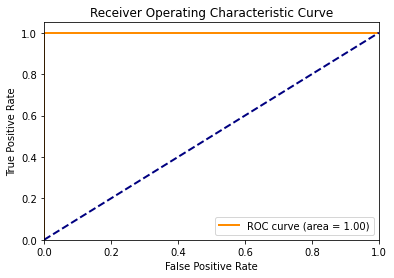

In [ ]:
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % train_roc_auc_rf,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic Curve")
plt.legend(loc="lower right")
plt.show()

What is the training set AUC of spamRF?

Ans: 1.00

## Naive Bayes

In [ ]:
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

MultinomialNB()

### Train Prediction

In [ ]:
train_pred_labels = nb_model.predict(X_train)

### Training Set Accuracy

In [ ]:
train_accuracy_naive_bayes = accuracy_score(y_train, train_pred_labels) * 100
print('Training Accuracy (Naive Bayes): ', round(train_accuracy_naive_bayes, 4), "%")

Training Accuracy (Naive Bayes):  99.6009 %


### Training Set ROC Curve and AUC

In [ ]:
y_prob = nb_model.predict_proba(X_test)

y_prob = y_prob[:, 1]

n_classes = len(nb_model.classes_)

fpr, tpr,_ = roc_curve(y_test, y_prob)
train_roc_auc_nb = auc(fpr, tpr)

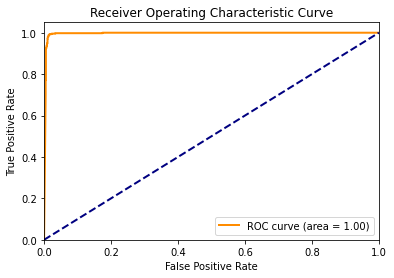

In [ ]:
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % train_roc_auc_nb,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic Curve")
plt.legend(loc="lower right")
plt.show()

## CART

In [ ]:
spamCART = DecisionTreeClassifier(criterion='gini')
spamCART.fit(X_train, y_train)

DecisionTreeClassifier()

### Train Prediction

In [ ]:
train_cart_pred_labels = spamCART.predict(X_train)

### Training Set Accuracy

In [ ]:
train_accuracy_cart = accuracy_score(y_train, train_cart_pred_labels) * 100
print('Training Accuracy (CART): ', round(train_accuracy_cart, 4), "%")

Training Accuracy (CART):  100.0 %


What is the training set accuracy of spamCART, using a threshold of 0.5 for predictions?

Ans: 100%

### Training Set ROC Curve and AUC

In [ ]:
y_prob = spamCART.predict_proba(X_test)

y_prob = y_prob[:, 1]

n_classes = len(spamCART.classes_)

fpr, tpr,_ = roc_curve(y_test, y_prob)
train_roc_auc_cart = auc(fpr, tpr)

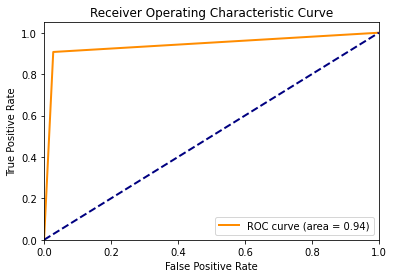

In [ ]:
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % train_roc_auc_cart,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic Curve")
plt.legend(loc="lower right")
plt.show()

What is the training set AUC of spamCART?

Ans: 0.94

## Comparison of Result

In [ ]:
training_results_table = PrettyTable(['Model','Accuracy (%)', "Area Under Curve(AUC)"])
training_results_table.add_row(['Random Forest', round(train_accuracy_rf, 4), round(train_roc_auc_rf,4) ])
training_results_table.add_row(['Naive Bayes', round(train_accuracy_naive_bayes, 4), round(train_roc_auc_nb,4)  ])
training_results_table.add_row(['CART', round(train_accuracy_cart, 4), round(train_roc_auc_cart,4) ])
print(training_results_table)

+---------------+--------------+-----------------------+
|     Model     | Accuracy (%) | Area Under Curve(AUC) |
+---------------+--------------+-----------------------+
| Random Forest |    100.0     |          1.0          |
|  Naive Bayes  |   99.6009    |         0.996         |
|      CART     |    100.0     |         0.9398        |
+---------------+--------------+-----------------------+


From the above table, we can see that the traing accuracy of Random Forest and CART model is 100%. The training set AUC of Random Forest (1.0) is more than CART (0.9398) model.

## Problem 4.1 – Evaluating on the Test Set

## Random Forest

### Prediction

In [ ]:
rf_pred_labels = spamRF.predict(X_test)

### Accuracy

In [ ]:
accuracy_rf = accuracy_score(y_test, rf_pred_labels) * 100
print('Accuracy (Random Forest): ', round(accuracy_rf, 4), "%")

Accuracy (Random Forest):  97.2077 %


What is the testing set accuracy of spamRF, using a threshold of 0.5 for predictions?

Ans: 97.2077 %

### Confusion Matrix

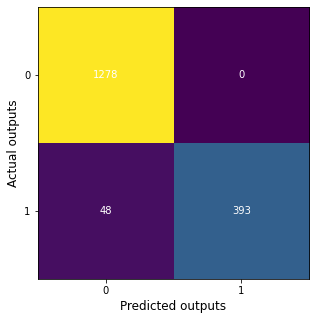

In [ ]:
cm = confusion_matrix(y_test, rf_pred_labels)

fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(cm)
ax.grid(False)
ax.set_xlabel('Predicted outputs', fontsize=12, color='black')
ax.set_ylabel('Actual outputs', fontsize=12, color='black')
ax.xaxis.set(ticks=range(2))
ax.yaxis.set(ticks=range(2))
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='white')
plt.show()

### Specificity

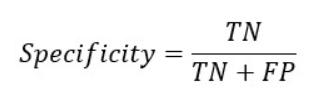

In [ ]:
specificity_rf = cm[0,0]/(cm[0,0]+cm[0,1]) * 100
print('Specificity (Random Forest): ', round(specificity_rf, 4), "%")

Specificity (Random Forest):  100.0 %


### Sensitivity

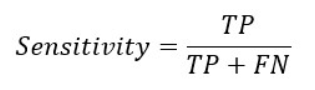

In [ ]:
sensitivity_rf = cm[1,1]/(cm[1,0]+cm[1,1]) * 100
print('Sensitivity (Random Forest): ', round(sensitivity_rf, 4), "%")

Sensitivity (Random Forest):  89.1156 %


### Classification Report

In [ ]:
print(classification_report(y_test, rf_pred_labels))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1278
           1       1.00      0.89      0.94       441

    accuracy                           0.97      1719
   macro avg       0.98      0.95      0.96      1719
weighted avg       0.97      0.97      0.97      1719



### ROC Curve and AUC

In [ ]:
y_prob = spamRF.predict_proba(X_test)

y_prob = y_prob[:, 1]

n_classes = len(spamRF.classes_)

fpr, tpr,_ = roc_curve(y_test, y_prob)
roc_auc_rf = auc(fpr, tpr)

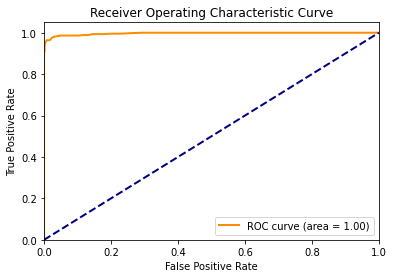

In [ ]:
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc_rf,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic Curve")
plt.legend(loc="lower right")
plt.show()

What is the testing set AUC of spamRF?

Ans: 1.00

## Naive Bayes

### Prediction

In [ ]:
pred_labels = nb_model.predict(X_test)

### Accuracy

In [ ]:
accuracy_naive_bayes = accuracy_score(y_test, pred_labels) * 100
print('Accuracy (Naive Bayes): ', round(accuracy_naive_bayes, 4), "%")

Accuracy (Naive Bayes):  98.5457 %


### Confusion Matrix

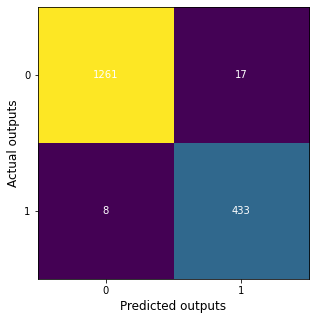

In [ ]:
cm = confusion_matrix(y_test, pred_labels)

fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(cm)
ax.grid(False)
ax.set_xlabel('Predicted outputs', fontsize=12, color='black')
ax.set_ylabel('Actual outputs', fontsize=12, color='black')
ax.xaxis.set(ticks=range(2))
ax.yaxis.set(ticks=range(2))
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='white')
plt.show()

### Specificity

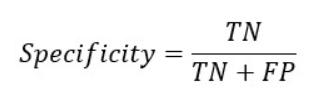

In [ ]:
specificity_naive_bayes = cm[0,0]/(cm[0,0]+cm[0,1]) * 100
print('Specificity (Naive Bayes): ', round(specificity_naive_bayes, 4), "%")

Specificity (Naive Bayes):  98.6698 %


### Sensitivity

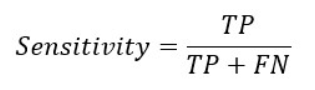

In [ ]:
sensitivity_naive_bayes = cm[1,1]/(cm[1,0]+cm[1,1]) * 100
print('Sensitivity (Naive Bayes): ', round(sensitivity_naive_bayes, 4), "%")

Sensitivity (Naive Bayes):  98.1859 %


### Classification Report

In [ ]:
print(classification_report(y_test, pred_labels))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1278
           1       0.96      0.98      0.97       441

    accuracy                           0.99      1719
   macro avg       0.98      0.98      0.98      1719
weighted avg       0.99      0.99      0.99      1719



### ROC Curve and AUC

In [ ]:
y_prob = nb_model.predict_proba(X_test)

y_prob = y_prob[:, 1]

n_classes = len(nb_model.classes_)

fpr, tpr,_ = roc_curve(y_test, y_prob)
roc_auc_nb = auc(fpr, tpr)

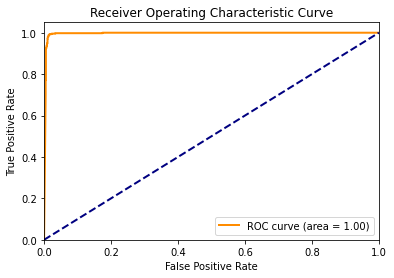

In [ ]:
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc_nb,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic Curve")
plt.legend(loc="lower right")
plt.show()

## CART

### Prediction

In [ ]:
cart_pred_labels = spamCART.predict(X_test)

### Accuracy

In [ ]:
accuracy_cart = accuracy_score(y_test, cart_pred_labels) * 100
print('Accuracy (CART): ', round(accuracy_cart, 4), "%")

Accuracy (CART):  95.5788 %


What is the testing set accuracy of spamCART, using a threshold of 0.5 for predictions?

Ans: 95.5788 %

### Confusion Matrix

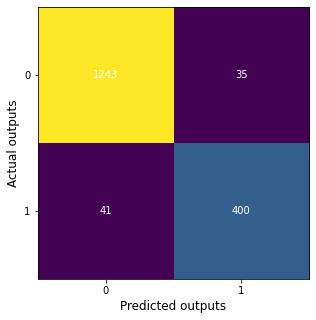

In [ ]:
cm = confusion_matrix(y_test, cart_pred_labels)

fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(cm)
ax.grid(False)
ax.set_xlabel('Predicted outputs', fontsize=12, color='black')
ax.set_ylabel('Actual outputs', fontsize=12, color='black')
ax.xaxis.set(ticks=range(2))
ax.yaxis.set(ticks=range(2))
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='white')
plt.show()

### Specificity

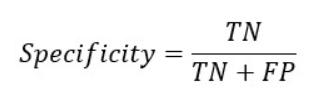

In [ ]:
specificity_cart = cm[0,0]/(cm[0,0]+cm[0,1]) * 100
print('Specificity (CART): ', round(specificity_cart, 4), "%")

Specificity (CART):  97.2613 %


### Sensitivity

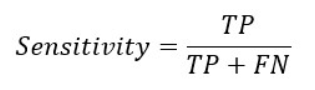

In [ ]:
sensitivity_cart = cm[1,1]/(cm[1,0]+cm[1,1]) * 100
print('Sensitivity (CART): ', round(sensitivity_cart, 4), "%")

Sensitivity (CART):  90.7029 %


### Classification Report

In [ ]:
print(classification_report(y_test, cart_pred_labels))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1278
           1       0.92      0.91      0.91       441

    accuracy                           0.96      1719
   macro avg       0.94      0.94      0.94      1719
weighted avg       0.96      0.96      0.96      1719



### ROC Curve and AUC

In [ ]:
y_prob = spamCART.predict_proba(X_test)

y_prob = y_prob[:, 1]

n_classes = len(spamCART.classes_)

fpr, tpr,_ = roc_curve(y_test, y_prob)
roc_auc_cart = auc(fpr, tpr)

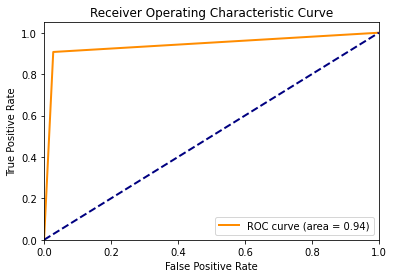

In [ ]:
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc_cart,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic Curve")
plt.legend(loc="lower right")
plt.show()

What is the testing set AUC of spamCART?

Ans: 0.94

## Comparison of Results

In [ ]:
results_table = PrettyTable(['Model','Accuracy (%)', 'Specificity (%)', 'Sensitivity (%)', "Area Under Curve(AUC)"])
results_table.add_row(['Random Forest', round(accuracy_rf, 4),  round(specificity_rf, 4), round(sensitivity_rf, 4), round(roc_auc_rf,4) ])
results_table.add_row(['Naive Bayes', round(accuracy_naive_bayes, 4), round(specificity_naive_bayes, 4),round(sensitivity_naive_bayes, 4), round(roc_auc_nb,4)  ])
results_table.add_row(['CART', round(accuracy_cart, 4), round(specificity_cart, 4), round(sensitivity_cart, 4), round(roc_auc_cart,4) ])
print(results_table)

+---------------+--------------+-----------------+-----------------+-----------------------+
|     Model     | Accuracy (%) | Specificity (%) | Sensitivity (%) | Area Under Curve(AUC) |
+---------------+--------------+-----------------+-----------------+-----------------------+
| Random Forest |   97.2077    |      100.0      |     89.1156     |         0.9968        |
|  Naive Bayes  |   98.5457    |     98.6698     |     98.1859     |         0.996         |
|      CART     |   95.5788    |     97.2613     |     90.7029     |         0.9398        |
+---------------+--------------+-----------------+-----------------+-----------------------+


Which model had the best testing set performance, in terms of accuracy and AUC? - CART or Random Forest

Ans: Random Forest has the best testing performance compared to CART in terms of accuracy and AUC.

# Inference

1. The email dataset had uneven class distribution with 1368 spam emails and 4360 ham emails.
In this experiment, I performed text analysis for separating spam email from ham.
2. A spam classifier can potentially benefit from including the frequency of the word that appears in every email.
3. Random Forest model outperformed CART model in terms of Accuracy and AUC.
5. This is because Random forests consist of multiple single trees each based on a random sample of the training data. They are typically more accurate than single decision trees.
6. While a single decision tree like CART is often pruned, a random forest tree is fully grown and unpruned, and so, naturally, the feature space is split into more and smaller regions.
7. Each random forest tree is learned on a random sample, and at each node, a random set of features are considered for splitting. Both mechanisms create diversity among the trees.